SPAM MESSAGE CLASSIFIER <br>
Zuhayer Alvi <br>
CSC 44700 

For this project, we will create a spam message classifier using a public dataset from Kaggle (https://tinyurl.com/dsr5dww5)

The goal of this project is to classify messages as "spam" or "not spam" based on their content. <br>
By training a machine learning model on this labeled dataset, the model will learn to recognize patterns associated <br>
with spam messages, such as certain keywords, special characters, and the frequency of certain words. <br>


In [46]:
# Import all libraries needed
import string 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

from wordcloud import WordCloud

In [17]:
# Download nltk stop words package
# This package essentially has a collection of all commonly used words that can be removed from a text to focus on more important words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zuzu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Read and create a dataframe of our CSV file
df = pd.read_csv('spam_ham_dataset.csv')

# Take a look at the data frame
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


As we can see, this data frame has 4 columns and 5171 rows in total. <br> 

For this project, we only need to care about the 'text' and 'label_num' columns of this data frame. <br>
For all entries within the 'text' column, we will remove all linebreaks (\r and \n) and replace them with whitespace. <br>
This will allow us to ensure uniformality within the data frame. 

In [19]:
# Replace all \r and \n with whitespace
df['text'] = df['text'].apply(lambda x: x.replace('\r\n', ' '))

# Take a look at the new dataframe
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291 thi...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001 ( see at...",0
2,3624,ham,"Subject: neon retreat ho ho ho , we ' re aroun...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs this deal is to b...,0


In [20]:
# Now check the dataframe for any missing or nonexistant values 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None


As we can see, there are no missing or nonexistant values within our dataset. <br>
Now we will visualize our dataset to better understand the data we are working with. <br>

C:\Users\zuzu\AppData\Local\Temp\ipykernel_15848\3620119525.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


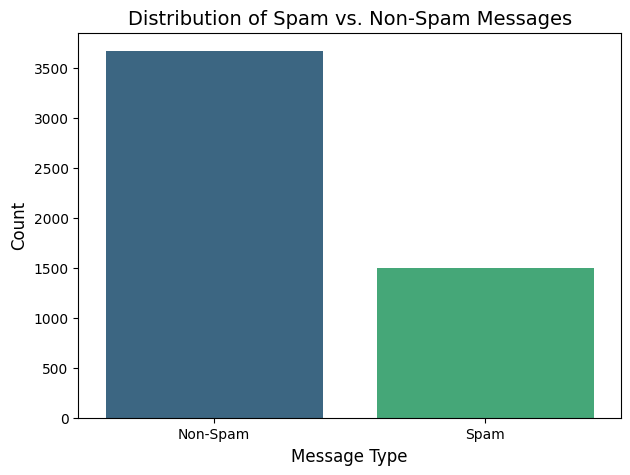

In [48]:
# Visualize the count of spam vs. non-spam messages using a bar plot
label_counts = df['label'].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Spam vs. Non-Spam Messages", fontsize=14)
plt.xlabel("Message Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ["Non-Spam", "Spam"], fontsize=10)
plt.show()

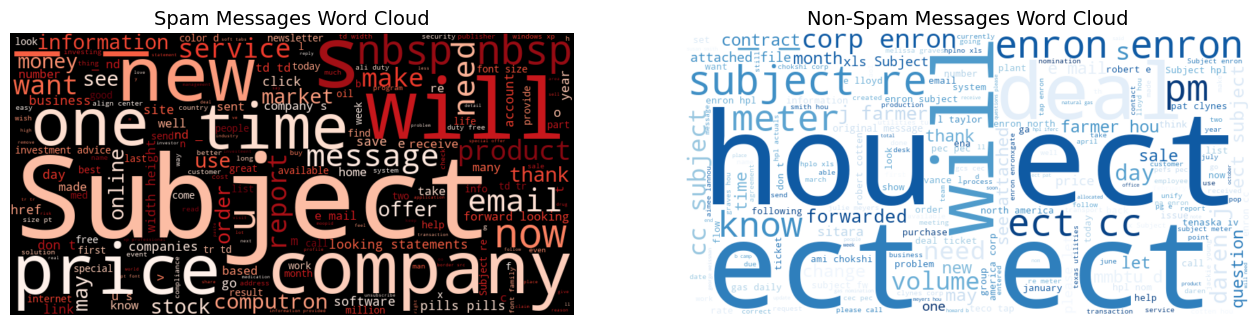

In [22]:
# Using wordcloud to visualize he most common words in spam and non-spam messages
spam_messages = " ".join(df[df['label'] == 'spam']['text'])  # Filtering spam messages
spam_wordcloud = WordCloud(
    width=800, height=400, background_color='black', colormap='Reds'
).generate(spam_messages)

# Generate Word Cloud for Ham (Non-Spam) Messages
nonspam_messages = " ".join(df[df['label'] == 'ham']['text'])  # Filtering non spam messages
nonspam_wordcloud = WordCloud(
    width=800, height=400, background_color='white', colormap='Blues'
).generate(nonspam_messages)

# Plot the Word Clouds
plt.figure(figsize=(16, 8))

# Spam Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Spam Messages Word Cloud", fontsize=14)
plt.axis("off")

# Ham Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(nonspam_wordcloud, interpolation='bilinear')
plt.title("Non-Spam Messages Word Cloud", fontsize=14)
plt.axis("off")

plt.show()

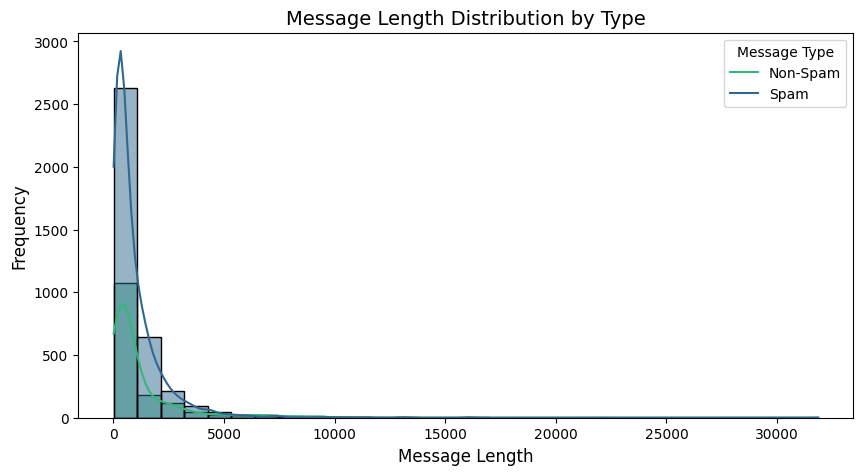

In [23]:
# Now analyze the lengths of messages for spam and non-spam messages using a histogram
df['message_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='message_length', hue='label', bins=30, kde=True, palette='viridis')
plt.title("Message Length Distribution by Type", fontsize=14)
plt.xlabel("Message Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(labels=["Non-Spam", "Spam"], title="Message Type")
plt.show()

In [24]:
# Begin with pre processing of all text: make everything lowercase, stem words to shorten them, and remove any punctuation
stemmer = PorterStemmer()
transformed_list = []
stopwords_set = set(stopwords.words('english'))

for i in range(len(df)):
    text = df['text'].iloc[i].lower()
    text = text.translate(str.maketrans('', '', string.punctuation)).split()
    text = [stemmer.stem(word) for word in text if word not in stopwords_set]
    text = ' '.join(text)
    transformed_list.append(text)

In [25]:
# Take a look at a text entry BEFORE changes
print(df.text.iloc[0])

Subject: enron methanol ; meter # : 988291 this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary flow data provided by daren } . please override pop ' s daily volume { presently zero } to reflect daily activity you can obtain from gas control . this change is needed asap for economics purposes .


In [26]:
# Take a look at a text entry AFTER the changes 
print(transformed_list[0])

subject enron methanol meter 988291 follow note gave monday 4 3 00 preliminari flow data provid daren pleas overrid pop daili volum present zero reflect daili activ obtain ga control chang need asap econom purpos


Now we will begin with training our model. <br>
We will utilize the 'RandomForestClassifier' machine learning model provided within the scikitlearn library. <br>
This learning model combines multiple decision trees to make predictions. <br>
We will utlize other models provided to us such as 'Naive Bayes' model later on and compare efficiency. <br>

In [ ]:
# Initialize a CountVectorizer(), which converts collections of text into matrix of token counts
vectorizer = CountVectorizer()

x = vectorizer.fit_transform(transformed_list).toarray()
y = df.label_num

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [37]:
# Initialize RandomForestClassifier 
clf = RandomForestClassifier(n_jobs = -1)

# Trains RandomForestClassifier on the training data
clf.fit(x_train, y_train)

# Compute the accuracy of the trained model on the testing data
print('The accuracy of the RFC trained model is ' + str(clf.score(x_test, y_test) * 100) + ' %')

The accuracy of the RFC trained model is 97.10144927536231 %


In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')

print("Cross-validation scores for each fold:", cv_scores * 100)
print("Mean cross-validation accuracy:", np.mean(cv_scores * 100))
print("Standard deviation of cross-validation accuracy:", np.std(cv_scores))

Cross-validation scores for each fold: [98.26086957 97.48549323 97.48549323 96.71179884 96.61508704]
Mean cross-validation accuracy: 97.31174838112858
Standard deviation of cross-validation accuracy: 0.006010793696570764


[[731  15]
 [ 15 274]]


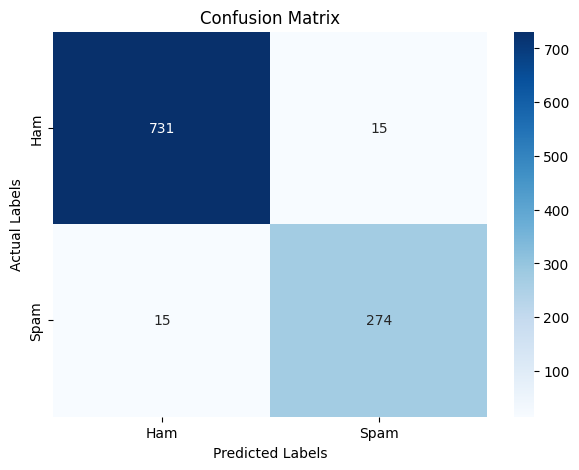

In [41]:
# Prediction and metrics of trained model
y_pred = clf.predict(x_test)

# Display confusion matrix 
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.show()

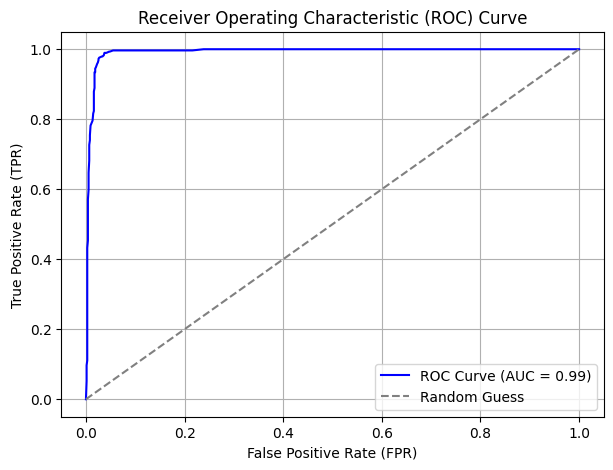

In [ ]:
# Get the predicted probabilities for the positive class (spam)
y_prob = clf.predict_proba(x_test)[:, 1]  # Probability of class "1" (spam)

# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The ROC-AUC curve we implemented above allows us to visualize the tradeoff between the True Positive Rate and False Positive Rate of different thresholds. <br>
As we can see from the graph, the model achieved a high AUC value of 0.99, which indicates excellent model performance. <br>

In [49]:
# Print out classification report: precision, recall, F1-score, and support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       746
           1       0.95      0.95      0.95       289

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



As we can see from the classification report output, <br>
The model has obtained an average of 0.97 for PRECISION, 0.97 for RECALL, and 0.97 for the F1-SCORE <br>

Next, we will try and understand the model's weaknesses by examining misclassified text samples. <br>

In [ ]:
# Predict on the test set
y_pred = clf.predict(x_test)

# Identify misclassified samples
misclassified_indices = (y_test != y_pred)

# Extract misclassified examples
misclassified_samples = x_test[misclassified_indices]
misclassified_true_labels = y_test[misclassified_indices]
misclassified_predicted_labels = y_pred[misclassified_indices]

# Decode misclassified text samples
misclassified_texts = vectorizer.inverse_transform(misclassified_samples)

# Display misclassified samples with true and predicted labels
print("Misclassified Samples:")
for i in range(len(misclassified_texts)):
    print(f"\nText: {misclassified_texts[i]}")
    print(f"True Label: {misclassified_true_labels.iloc[i]} | Predicted Label: {misclassified_predicted_labels[i]}")

Misclassified Samples:

Text: ['01' '04' '058' '0600' '07080' '08' '09' '10' '11' '121' '13' '15' '18'
 '181' '19' '20' '2000' '2004' '21' '2144' '22' '23' '24' '27' '28' '29'
 '43' '45' '4619' '60' '636' '789' '82' '83976' '84' '85' '87' '879' '90'
 '91' '92' '93' '94' '95' '96' '97' '98' '99' 'aa' 'ab' 'ac' 'ad' 'ae'
 'al' 'alfredo' 'america' 'auto' 'ba' 'bb' 'bd' 'beattyvil' 'begin'
 'block' 'bo' 'borrett' 'box' 'ca' 'cad' 'cc' 'cch' 'cd' 'cdu' 'ce' 'ced'
 'cejf' 'chasejurist' 'cir' 'cl' 'clc' 'co' 'cokeryenw' 'commission'
 'contract' 'da' 'dalla' 'df' 'dfbe' 'directori' 'dl' 'document' 'doue'
 'ea' 'edlm' 'eg' 'el' 'email' 'end' 'eo' 'fa' 'fcm' 'fe' 'feel' 'feop'
 'ff' 'flz' 'fo' 'fs' 'fu' 'gener' 'goodbyeion' 'hollon' 'home' 'inc' 'jj'
 'kong' 'ky' 'lee' 'level' 'limitedd' 'locat' 'mar' 'market' 'master'
 'messag' 'messagelogin' 'mid' 'mobil' 'multi' 'name' 'net' 'oct' 'phone'
 'plainfield' 'platform' 'pleas' 'po' 'profileswindow' 'repli' 'road'
 'sad' 'seed' 'set' 'singl' 'south'